In [1]:
# 繪圖設定字體顏色(否則黑色會看不到)
import matplotlib as mpl
COLOR1 = 'red'
COLOR2 = 'blue'
mpl.rcParams['text.color'] = COLOR1
mpl.rcParams['axes.labelcolor'] = COLOR2
mpl.rcParams['xtick.color'] = COLOR2
mpl.rcParams['ytick.color'] = COLOR2

# 預訓模型VGG16 x tensorflow 2.0辨識貓狗

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from skimage import data, color, io
from skimage.transform import rescale, resize
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import tensorflow as tf

# 1.模型設定
    # (1)VGG16 with include_top=False
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
print(model_vgg16_conv.summary())
    # (2)前面接上 自訂input
img_width, img_height = 224, 224             # input資料格式 寬、高
input_shape = (img_height, img_width, 3)     # 自訂input format (224 x 224 x 3)
input_layer = tf.keras.Input(shape=input_shape, name='image_input')
output_vgg16_conv = model_vgg16_conv(input_layer)
    # (3)後面接上 打平降維 + FCN
num_classes = 2     # 類別個數
x = tf.keras.layers.Flatten(name='flatten')(output_vgg16_conv)
# x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dense(256, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(x)
    # (4)模型定義input, output
model = tf.keras.Model(inputs=input_layer, outputs=x)
print(model.summary())
    # (5)設定損失函數、優化器
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

# 2.使用自己的圖片訓練：Data Augmentation(旋轉、裁剪、放大縮小、水平翻轉)
    # 訓練資料路徑
train_data_dir = 'train'
    # 設定ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)
    # 生成器 不斷生成：從flow_from_directory目錄下產生(2類45張圖片)
batch_size = 15
train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, 
    shuffle=False, class_mode='categorical')
print('檔案名稱\n', train_generator.filenames)
print('檔案總數 =', len(train_generator.filenames))
print('label\n', train_generator.classes)
print('種類 =', train_generator.num_classes)
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, 
    shuffle=False, class_mode='categorical')
# 3.訓練
epochs = 5
train_history = model.fit_generator(
    train_generator, steps_per_epoch=len(train_generator.filenames)/batch_size, 
    epochs=epochs, validation_data=validation_generator, 
    validation_steps=len(validation_generator.filenames)/batch_size)

# # 4.訓練結果存檔
# model.save('model.h5')
# # 載入模型
# model = tf.keras.models.load_model('model.h5')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

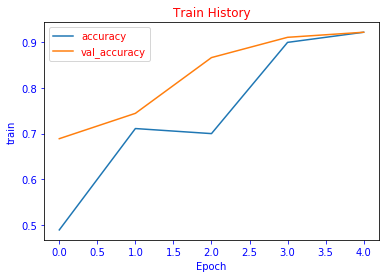

In [3]:
# 繪圖
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel('train')
    plt.legend([train, validation], loc='upper left')
    plt.show()
show_train_history(train_history, 'accuracy', 'val_accuracy')

類別名稱 = cat
貓狗機率 = [0.9999981 0.       ]


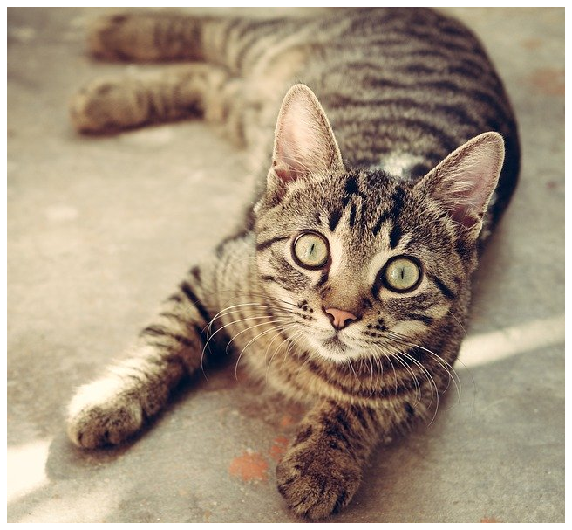

In [10]:
# 5.預測-1
    # (1)載入需要預測的圖片 + 前處理
img_path = 'cat.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
    # (2)資料預測：類別、機率
labels = ['cat', 'dog']
predictions = model.predict(x)
# include_top=True 才可執行
    # 取得最可能的索引值、名稱、機率
print('類別名稱 =', labels[np.argmax(predictions)])
print('貓狗機率 =', predictions.ravel())

plt.figure(figsize=(10, 10))
image = io.imread(img_path)
plt.axis('off')
plt.imshow(image)

類別名稱 = cat
貓狗機率 = [0.9992644 0.9897871]


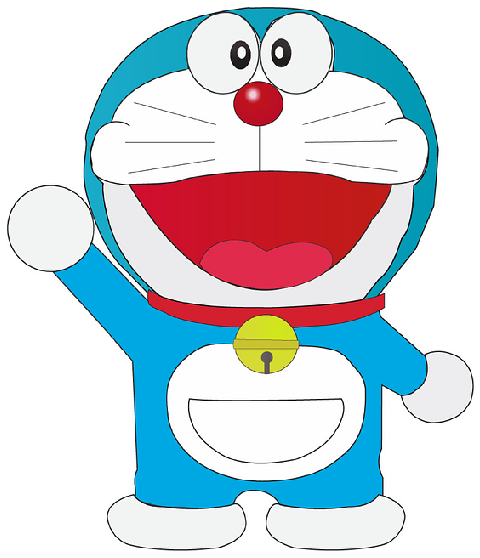

In [11]:
# 5.預測-2
    # (1)載入需要預測的圖片 + 前處理
img_path2 = 'dora.png'
img = tf.keras.preprocessing.image.load_img(img_path2, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
    # (2)資料預測：類別、機率
labels = ['cat', 'dog']
predictions = model.predict(x)
# include_top=True 才可執行
    # 取得最可能的索引值、名稱、機率
print('類別名稱 =', labels[np.argmax(predictions)])
print('貓狗機率 =', predictions.ravel())

plt.figure(figsize=(10, 10))
image = io.imread(img_path2)
plt.axis('off')
plt.imshow(image)